[DEBUG] Mean Center Pixel: 0.0
[INFO] Lesi terdeteksi Hitam -> Melakukan Inversi.
[INFO] Mengisolasi objek tengah dan mengisi lubang...
[SUCCESS] Starting Pixel ditemukan di: (np.int64(475), 152)


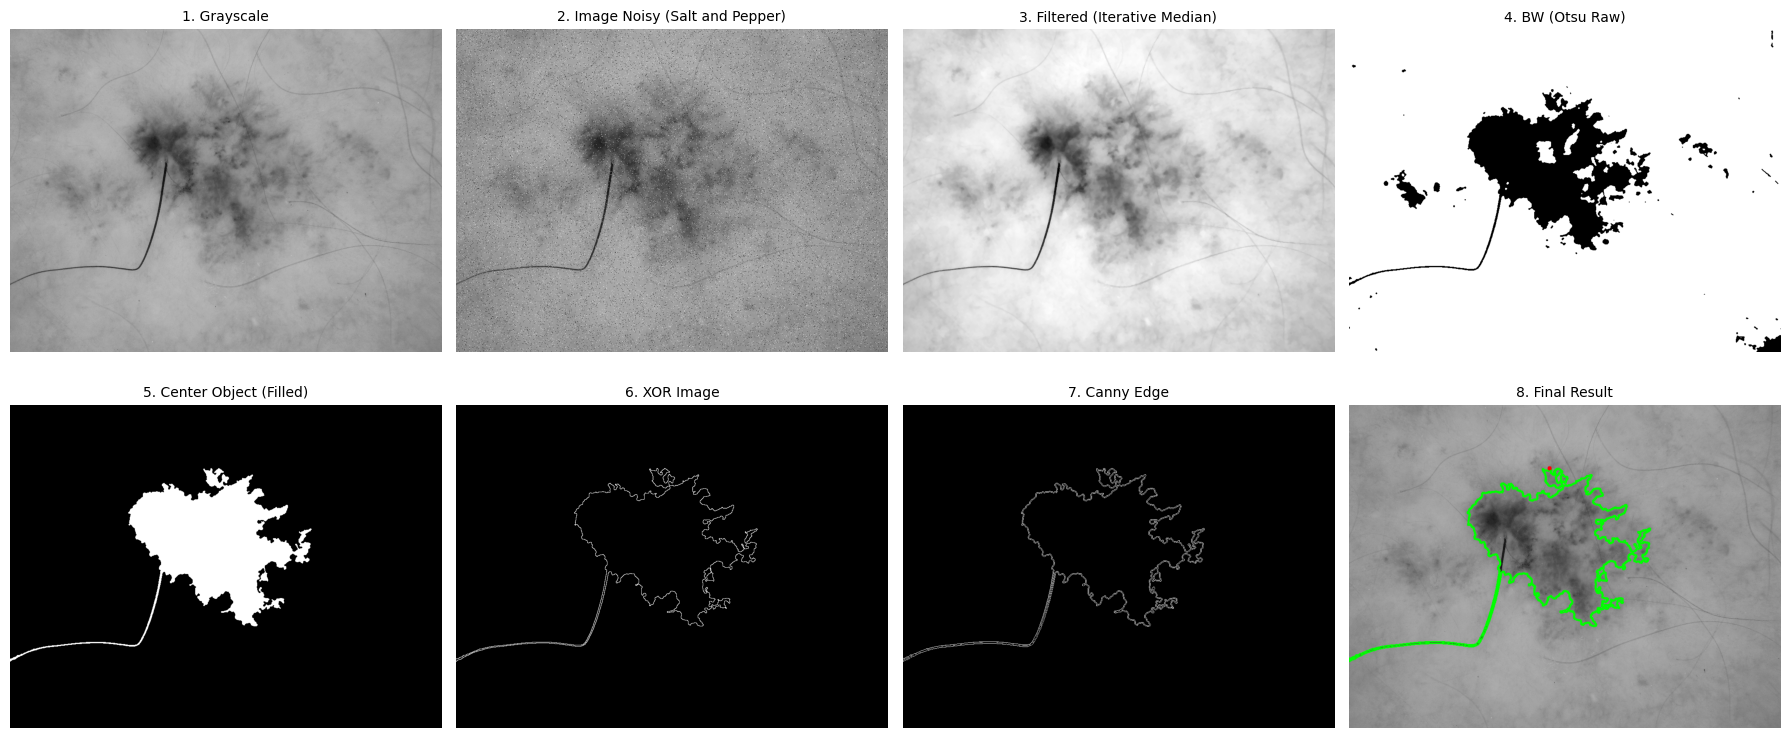

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path

# --- HELPER FUNCTIONS ---

def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    """Step 2: Menambahkan Salt and Pepper Noise"""
    noisy = np.copy(image)
    total_pixels = image.size
    
    # Add Salt (Putih)
    num_salt = np.ceil(salt_prob * total_pixels)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy[tuple(coords)] = 255

    # Add Pepper (Hitam)
    num_pepper = np.ceil(pepper_prob * total_pixels)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy[tuple(coords)] = 0
    return noisy

def iterative_median_filter(image, iterations=3, ksize=3):
    """Step 3: Iterative Median Filter"""
    filtered = image.copy()
    for i in range(iterations):
        filtered = cv2.medianBlur(filtered, ksize)
    return filtered

def keep_center_object_only(mask):
    """
    Hanya mengambil objek di tengah.
    Menggunakan logika 'Intersection' yang lebih ketat agar tidak mengambil kulit.
    """
    h, w = mask.shape
    center_x, center_y = w // 2, h // 2
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    mask_center = np.zeros_like(mask)
    valid_contours = []
    
    for cnt in contours:
        # Cek apakah titik tengah gambar ada DI DALAM kontur tersebut?
        # Method: PointPolygonTest.  
        # > 0 (inside), = 0 (on edge), < 0 (outside)
        dist = cv2.pointPolygonTest(cnt, (center_x, center_y), False)
        
        if dist >= 0:
            valid_contours.append(cnt)
            
    if len(valid_contours) > 0:
        c_max = max(valid_contours, key=cv2.contourArea)
        cv2.drawContours(mask_center, [c_max], -1, 255, thickness=cv2.FILLED)
        return mask_center
    else:
        # Fallback: Jika titik tengah persis tidak kena, pakai bounding box method (lebih longgar)
        for cnt in contours:
            x, y, cw, ch = cv2.boundingRect(cnt)
            if x <= center_x <= x+cw and y <= center_y <= y+ch:
                valid_contours.append(cnt)
        
        if len(valid_contours) > 0:
            c_max = max(valid_contours, key=cv2.contourArea)
            cv2.drawContours(mask_center, [c_max], -1, 255, thickness=cv2.FILLED)
            return mask_center
            
        return np.zeros_like(mask) # Return hitam jika gagal total

def find_starting_pixel_step7(binary_img, edge_img):
    """Step 7.1: Mencari koordinat awal (Starting Pixel)"""
    rows, cols = binary_img.shape
    start_point = None
    
    for r in range(rows):
        if np.sum(binary_img[r, :]) > 0:
            edge_row = edge_img[r, :]
            non_zero_indices = np.where(edge_row > 0)[0]
            
            if len(non_zero_indices) > 0:
                min_col = non_zero_indices.min()
                start_point = (min_col, r)
                break
    return start_point

# --- MAIN PIPELINE ---

def run_pipeline(img_path):
    # Cek path
    path_obj = Path(img_path)
    if not path_obj.exists():
        print(f"File tidak ditemukan: {img_path}")
        return

    # Step 1: RGB to Grayscale
    img_bgr = cv2.imread(str(path_obj))
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Step 2: Add Noise
    img_noisy = add_salt_and_pepper_noise(img_gray, salt_prob=0.02, pepper_prob=0.02)

    # Step 3: Iterative Median Filter
    img_filtered = iterative_median_filter(img_noisy, iterations=5, ksize=3)

    # Step 4: Thresholding (Otsu)
    _, img_bw_raw = cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    h, w = img_bw_raw.shape
    
    # Ambil area kecil di tengah (misal 20x20 pixel)
    center_region = img_bw_raw[h//2-10 : h//2+10, w//2-10 : w//2+10]
    mean_center = np.mean(center_region)
    
    print(f"[DEBUG] Mean Center Pixel: {mean_center}")

    # Jika tengah Dominan HITAM (< 127), berarti Lesi Hitam.
    # Kita butuh Lesi Putih -> Maka INVERT.
    if mean_center < 127:
        print("[INFO] Lesi terdeteksi Hitam -> Melakukan Inversi.")
        img_bw_fixed = cv2.bitwise_not(img_bw_raw)
    else:
        print("[INFO] Lesi terdeteksi Putih -> Normal.")
        img_bw_fixed = img_bw_raw

    # --- TAMBAHAN LOGIKA 2: KEEP CENTER ONLY ---
    # Membuang noise border dan mengisi lubang (donut fix) sebelum edge detection
    print("[INFO] Mengisolasi objek tengah dan mengisi lubang...")
    img_bw_clean = keep_center_object_only(img_bw_fixed)

    # Step 5: XOR Image (Morphological Edge)
    # Gunakan mask yang sudah bersih (img_bw_clean)
    kernel = np.ones((3,3), np.uint8)
    img_eroded = cv2.erode(img_bw_clean, kernel, iterations=1)
    img_xor = cv2.bitwise_xor(img_bw_clean, img_eroded)

    # Step 6: Canny Edge Detector
    img_canny = cv2.Canny(img_xor, 50, 150)

    # Step 7: Tracing
    start_pixel = find_starting_pixel_step7(img_bw_clean, img_canny)
    
    img_result = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    
    if start_pixel:
        print(f"[SUCCESS] Starting Pixel ditemukan di: {start_pixel}")
        contours, _ = cv2.findContours(img_canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Gambar kontur
        cv2.drawContours(img_result, contours, -1, (0, 255, 0), 2)
        # Gambar titik start
        cv2.circle(img_result, start_pixel, 5, (0, 0, 255), -1) 
    else:
        print("[WARNING] Tidak dapat menemukan starting pixel.")

    # --- VISUALISASI ---
    titles = [
        '1. Grayscale', '2. Image Noisy (Salt and Pepper)', '3. Filtered (Iterative Median)',
        '4. BW (Otsu Raw)', '5. Center Object (Filled)', 
        '6. XOR Image', '7. Canny Edge', '8. Final Result'
    ]

    images = [
        img_gray, img_noisy, img_filtered, img_bw_raw, img_bw_clean,
        img_xor, img_canny, cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)
    ]

    plt.figure(figsize=(18, 8))
    rows, cols = 2, 4  # jumlah subplot 2x4

    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        # final result tetap RGB, sisanya grayscale
        if i == 7:
            plt.imshow(images[i])
        else:
            plt.imshow(images[i], cmap='gray')
        plt.title(titles[i], fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# --- EKSEKUSI ---
# Pastikan path ini benar
image_path = "./Dataset/ISBI2016_ISIC_Part3_Training_Data/ISIC_0011397.jpg" 

try:
    run_pipeline(image_path)
except Exception as e:
    print(f"Error executing pipeline: {e}")